In [ ]:
import h5py
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from vit_keras import vit

# Load the images and labels from file
with h5py.File('/content/drive/MyDrive/Galaxy10.h5', 'r') as F:
    labels = np.array(F['ans'])
images = np.load('/content/drive/MyDrive/galaxy10sdss/SDSSlevel_set_images.npy')

# Resize the images to (224, 224) and convert grayscale to RGB
images = np.array([cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_GRAY2RGB) for img in images])

# Convert the labels to categorical 10 classes
labels = tf.keras.utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(images.shape)
print(labels.shape)
print(np.unique(labels, axis=0))


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


(21785, 224, 224, 3)
(21785, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
images = images*255

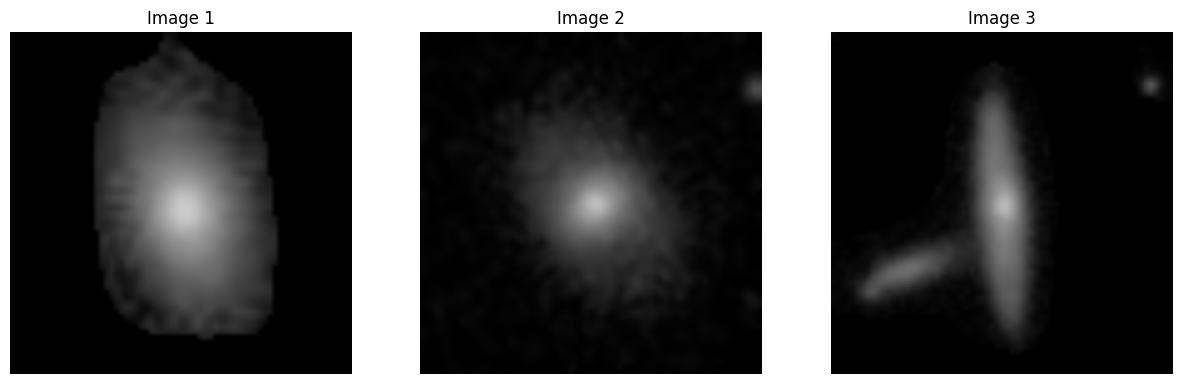

In [ ]:
import matplotlib.pyplot as plt
# Print the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Image {i+1}")
    ax.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Define learning rate schedule
initial_learning_rate = 1e-4
decay_steps = 1000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

# Split the data into train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Configure ImageDataGenerator for training data
datagen.fit(X_train)

vit_model = vit.vit_b16(  # Use ViT-e
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 10)

# Add a classification head to the model with dropout and L2 regularization
x = vit_model.output
x = Dropout(0.5)(x)  # Add dropout with rate 0.5
predictions = Dense(10, activation='softmax', kernel_regularizer=l2(0.001))(x)  # Add L2 regularization with weight 0.001
model = Model(inputs=vit_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Use early stopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Define the checkpoint path and file name
checkpoint_path = "/content/drive/MyDrive/vit16_SDSS_levelset_best_model.h5"

# Create a callback that saves the model's weights
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=False,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True)

# Train the model using data augmentation generator
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) // 32,
          epochs=15,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping, model_checkpoint])  # Add model_checkpoint to the callbacks


# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)



347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15
476/476 [==============================] - 278s 474ms/step - loss: 0.9144 - accuracy: 0.6846 - val_loss: 0.5463 - val_accuracy: 0.8167
Epoch 2/15
476/476 [==============================] - 229s 480ms/step - loss: 0.5960 - accuracy: 0.7958 - val_loss: 0.5449 - val_accuracy: 0.8112
Epoch 3/15
476/476 [==============================] - 228s 479ms/step - loss: 0.5259 - accuracy: 0.8211 - val_loss: 0.4440 - val_accuracy: 0.8464
Epoch 4/15
476/476 [==============================] - 231s 485ms/step - loss: 0.4831 - accuracy: 0.8342 - val_loss: 0.4179 - val_accuracy: 0.8666
Epoch 5/15
476/476 [==============================] - 213s 447ms/step - loss: 0.4541 - accuracy: 0.8436 - val_loss: 0.4697 - val_accuracy: 0.8320
Epoch 6/15
476/476 [==============================] - 213s 448ms/step - loss: 0.4085 - accuracy: 0.8623 - val_loss: 0.4394 - val_accuracy: 0.8537
Epoch 7/15
476/476 [==============================] - 227s 475ms/step - loss: 0.3891 - accuracy: 0.8676 - val_loss: 0.3784 -